After discussing with my mentor, we've decided that it's best we take an approach of assessing which datasets to use, rather than evaluating the models themselves. Given that the goal of the final project is to compare the performance of various models, it is likely we will include a variety of models regardless of their performance. As such, we will focus this exercise on examining the performance of various datasets.

Dataset 1: Time-series stock data (daily)

Dataset 2: Financial news + technical data

Dataset 3: Combination of time-series data + monthly production values (https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/09_time_series_models/02_arima_models.ipynb)

Dataset 4: Quandl? https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/data/create_datasets.ipynb

Approaches: 
1. RNN: See existing research
2. ARIMA: https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/09_time_series_models/02_arima_models.ipynb
3. K-means: https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/13_unsupervised_learning/03_clustering_algorithms/02_kmeans_implementation.ipynb
4. Gradient boosting: see stefan jansen

<h4> Section 0: Imports </h4>

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


<h4> Section 1: Time-series data from FRED (Federal Reserve Bank's Data Service) </h4>



In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

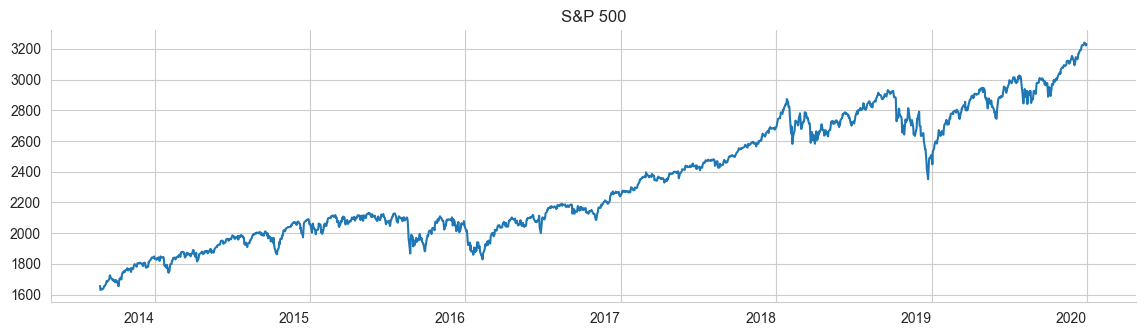

In [5]:
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [6]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.datasets import fetch_openml

pd.set_option('display.expand_frame_repr', False)

In [7]:
DATA_STORE = Path('assets.h5')

In [8]:
df = pd.read_csv('data/wiki_stocks.csv')
# no longer needed
# df = pd.concat([df.loc[:, 'code'].str.strip(),
#                 df.loc[:, 'name'].str.split('(', expand=True)[0].str.strip().to_frame('name')], axis=1)

print(df.info)
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/stocks', df)

<bound method DataFrame.info of      ticker                                               name
0         A  Agilent Technologies Inc. (A) Prices, Dividend...
1        AA  Alcoa Inc. (AA) Prices, Dividends, Splits and ...
2       AAL  American Airlines Group Inc. (AAL) Prices, Div...
3      AAMC  Altisource Asset Management (AAMC) Prices, Div...
4       AAN  Aaron's Inc. (AAN) Prices, Dividends, Splits a...
...     ...                                                ...
3176   ZNGA  Zynga Inc. (ZNGA) Prices, Dividends, Splits an...
3177   ZOES  Zoe's Kitchen Inc (ZOES) Prices, Dividends, Sp...
3178    ZQK  Quiksilver Inc. (ZQK) Prices, Dividends, Split...
3179    ZTS  Zoetis Inc (ZTS) Prices, Dividends, Splits and...
3180   ZUMZ  Zumiez Inc. (ZUMZ) Prices, Dividends, Splits a...

[3181 rows x 2 columns]>


In [9]:
df = (pd.read_csv('data/wiki_prices.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

print(df.info)

<bound method DataFrame.info of                      open    high     low   close      volume  ex-dividend  split_ratio   adj_open   adj_high    adj_low  adj_close    adj_volume
date       ticker                                                                                                                                
1962-01-02 ARNC     65.56   65.75   65.38   65.38      5600.0          0.0          1.0   3.458163   3.468185   3.448668   3.448668  4.480000e+04
           BA       50.88   50.88   50.00   50.00     11595.0          0.0          1.0   0.887160   0.887160   0.871816   0.871816  3.521981e+05
           CAT      38.50   38.87   38.12   38.50     13600.0          0.0          1.0   1.578370   1.593539   1.562791   1.578370  1.632000e+05
           DD      241.50  244.25  241.50  241.50      2000.0          0.0          1.0   4.718414   4.772144   4.718414   4.718414  3.600000e+04
           DIS      37.25   38.50   37.25   37.25      2098.0          0.0          1.0   0.

In [10]:
def get_data(start_date, end_date, ticker, df):
    idx = pd.IndexSlice
    new_df = df.loc[idx[start_date:end_date, ticker], :]
    return new_df

In [11]:
DEFAULT_START = '2008-01-01'
DEFAULT_END = '2018-01-01'

AAPL_df = get_data(DEFAULT_START, DEFAULT_END, 'AAPL', df)
AAPL_df.head(5)

,,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,ticker,,,,,,,,,,,,
2008-01-02,AAPL,199.27,200.26,192.55,194.84,38542100.0,0.0,1.0,25.608972,25.736201,24.745359,25.039656,269794700.0
2008-01-03,AAPL,195.41,197.39,192.69,194.93,30073800.0,0.0,1.0,25.112909,25.367366,24.763351,25.051222,210516600.0
2008-01-04,AAPL,191.45,193.00,178.89,180.05,51994000.0,0.0,1.0,24.603993,24.803190,22.989858,23.138934,363958000.0
2008-01-07,AAPL,181.25,183.60,170.23,177.64,74006900.0,0.0,1.0,23.293151,23.595159,21.876928,22.829216,518048300.0
2008-01-08,AAPL,180.14,182.46,170.80,171.25,54422000.0,0.0,1.0,23.150501,23.448653,21.950181,22.008012,380954000.0


In [93]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y


In [67]:
dat = AAPL_df.reset_index(level = [1])[['open']]
dat

,open
date,
2008-01-02,199.27
2008-01-03,195.41
2008-01-04,191.45
2008-01-07,181.25
2008-01-08,180.14
...,...
2017-12-22,174.68
2017-12-26,170.80
2017-12-27,170.10


In [95]:
### Normalize Data ###
scaler = MinMaxScaler()
aapl_scaled = pd.Series(scaler.fit_transform(dat).squeeze(), index=dat.index)

window_size = 63

window_size = 63

### Create Data ###
X, y = create_univariate_rnn_data(aapl_scaled, window_size=window_size)



In [98]:
### Train-test split ###

X, y = create_univariate_rnn_data(aapl_scaled, window_size=window_size)

### Train on data up to 2018 ###
X_train = X[:'2016'].values.reshape(-1, window_size, 1)
y_train = y[:'2016']

### Test on data from 2019 ###
X_test = X['2017':].values.reshape(-1, window_size, 1)
y_test = y['2017':]

n_obs, window_size, n_features = X_train.shape

y_train.shape

(2204,)

In [99]:
### Create RNN Model ###

rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
### Define optimizer for RNN ###

optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

### Compile RNN w/ previously defined optimizer ###
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

### Save best path of model during training ###
rnn_path = (results_path / 'rnn.h5').as_posix()

### Call best model during training ###
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

### Early stopping to prevent overfitting ###
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

### Train model ###
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=2)

Epoch 1/150

Epoch 1: val_loss improved from inf to 0.00015, saving model to results/univariate_time_series\rnn.h5
111/111 - 5s - loss: 0.0276 - val_loss: 1.5422e-04 - 5s/epoch - 41ms/step
Epoch 2/150

Epoch 2: val_loss improved from 0.00015 to 0.00003, saving model to results/univariate_time_series\rnn.h5
111/111 - 1s - loss: 0.0021 - val_loss: 3.1528e-05 - 1s/epoch - 13ms/step
Epoch 3/150

Epoch 3: val_loss improved from 0.00003 to 0.00002, saving model to results/univariate_time_series\rnn.h5
111/111 - 1s - loss: 0.0017 - val_loss: 2.4259e-05 - 1s/epoch - 13ms/step
Epoch 4/150

Epoch 4: val_loss did not improve from 0.00002
111/111 - 1s - loss: 0.0015 - val_loss: 1.6890e-04 - 1s/epoch - 12ms/step
Epoch 5/150

Epoch 5: val_loss did not improve from 0.00002
111/111 - 1s - loss: 0.0013 - val_loss: 2.5347e-05 - 1s/epoch - 13ms/step
Epoch 6/150

Epoch 6: val_loss did not improve from 0.00002
111/111 - 1s - loss: 0.0012 - val_loss: 8.8890e-05 - 1s/epoch - 13ms/step
Epoch 7/150

Epoch 7: v

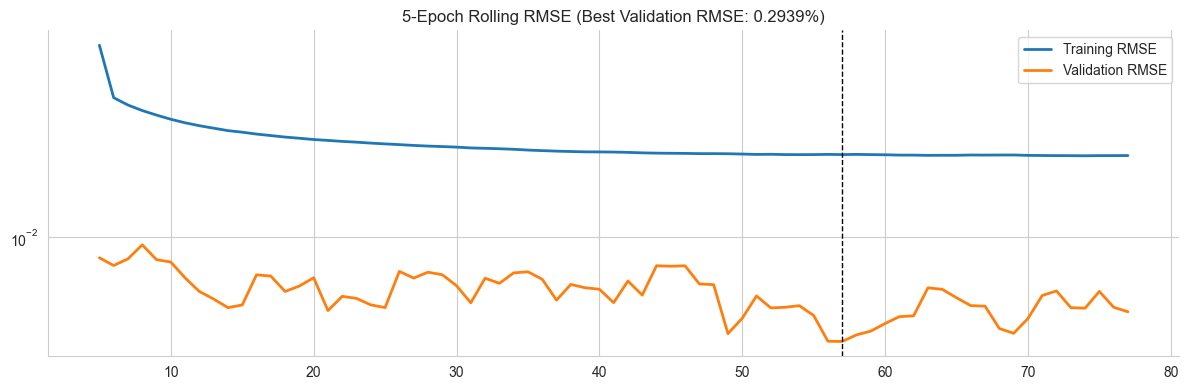

In [101]:
### Plot performance ###

fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300)

In [102]:
### More performance benchmarks ###

train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0216 | Test RMSE: 0.0029


In [103]:
### We trained on scaled data, therefore our predictions are in scaled form ###
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

### Correlation coefficient between predicted and actual values ###
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

8/8 [==============================] - 0s 3ms/step
Train IC: 0.9956 | Test IC: 0.9869


In [106]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [107]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

In [108]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

In [115]:
arima_dat = AAPL_df.reset_index(level = [1])['open']
arima_log = np.log(arima_dat)
arima_log

date
2008-01-02    5.294661
2008-01-03    5.275100
2008-01-04    5.254627
2008-01-07    5.199877
2008-01-08    5.193734
                ...   
2017-12-22    5.162956
2017-12-26    5.140493
2017-12-27    5.136386
2017-12-28    5.141664
2017-12-29    5.138853
Name: open, Length: 2516, dtype: float64

In [116]:
arima_model = tsa.ARIMA(endog=arima_log, order=(2,1,2)).fit()

C:\Users\jeffr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jeffr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jeffr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore